In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Dropout

In [ ]:
data = pd.read_csv('rawdata.csv')
data

,SAMPLE_ID,snp_0,snp_1,snp_2,snp_3,snp_4,snp_5,snp_6,snp_7,snp_8,snp_9,snp_10,snp_11,snp_12,snp_13,snp_14,snp_15,snp_16,snp_17,snp_18,snp_19,snp_20,snp_21,snp_22,snp_23,snp_24,snp_25,snp_26,snp_27,snp_28,snp_29,snp_30,snp_31,snp_32,snp_33,snp_34,snp_35,snp_36,snp_37,snp_38,...,snp_9962,snp_9963,snp_9964,snp_9965,snp_9966,snp_9967,snp_9968,snp_9969,snp_9970,snp_9971,snp_9972,snp_9973,snp_9974,snp_9975,snp_9976,snp_9977,snp_9978,snp_9979,snp_9980,snp_9981,snp_9982,snp_9983,snp_9984,snp_9985,snp_9986,snp_9987,snp_9988,snp_9989,snp_9990,snp_9991,snp_9992,snp_9993,snp_9994,snp_9995,snp_9996,snp_9997,snp_9998,snp_9999,snp_10000,STATUS
0,HCB181,1,0,0,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,0,0,2,2,2,2,1,1,2,2,2,2,2,2,0,0,0,0,2,2,...,1,2,2,1,2,1,2,2,1,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,1,2,1,2,1,2,1
1,HCB182,1,0,0,1,1,2,2,1,2,2,2,1,2,1,2,2,2,2,2,0,0,2,2,2,2,2,2,1,1,1,2,0,0,0,0,0,0,2,2,...,1,2,2,1,2,1,2,2,1,2,2,2,2,2,2,1,2,2,2,1,2,1,2,2,2,2,2,2,2,1,1,1,2,2,2,1,2,2,2,2
2,HCB183,1,0,0,1,2,2,2,1,2,2,2,1,2,1,1,2,2,2,2,0,0,2,2,2,2,1,2,1,2,1,2,2,2,0,0,0,0,2,2,...,1,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,1,2,2,2,1,2,2,2,1,2,2
3,HCB184,1,0,0,1,1,2,2,1,2,2,2,1,1,2,2,2,2,2,2,0,0,2,2,2,2,1,1,2,2,2,2,2,2,0,0,0,0,2,2,...,1,1,1,1,2,1,2,1,1,2,2,1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,1,2,2,2,1,2,2
4,HCB185,1,0,0,1,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,1,2,...,1,1,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,1,2,2,2,2,2,1,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,JPT265,1,0,0,1,1,1,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,1,1,2,2,1,1,2
85,JPT266,1,0,0,1,2,2,2,1,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,2,1,2,2,2,1,2,2,2,1,2,...,1,1,2,1,2,1,2,1,1,2,2,1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,1,2,2,2,1,2,2
86,JPT267,1,0,0,1,2,1,2,2,2,2,2,2,2,2,2,2,2,0,0,2,2,0,0,0,0,1,2,2,2,2,2,0,0,2,2,2,2,1,2,...,1,1,2,1,1,1,1,1,1,2,2,2,2,2,2,1,2,2,2,1,2,1,2,2,2,2,2,2,2,1,2,2,2,2,2,1,1,2,2,1
87,JPT268,1,0,0,1,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,...,1,2,2,1,1,1,1,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,1,2,1,2,1,1,1


In [ ]:
data[['SAMPLE_ID']] = LabelEncoder().fit_transform(data[['SAMPLE_ID']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Pada code diatas dapat dilihat bahwa saya mengubah atau mengencode bagian kolom SAMPLE_ID yang awalnya bertipe string menjadi integer dengan menggunakan label encoder dengan tujuan untuk mempermudah proses training nantinya.**

In [ ]:
features = data.drop('STATUS', axis=1)
label = data['STATUS']
print('Features :\n', features)
print('Labels : \n', label)

Features :
     SAMPLE_ID  snp_0  snp_1  snp_2  ...  snp_9997  snp_9998  snp_9999  snp_10000
0           0      1      0      0  ...         1         2         1          2
1           1      1      0      0  ...         1         2         2          2
2           2      1      0      0  ...         2         2         1          2
3           3      1      0      0  ...         2         2         1          2
4           4      1      0      0  ...         2         2         2          2
..        ...    ...    ...    ...  ...       ...       ...       ...        ...
84         84      1      0      0  ...         2         2         1          1
85         85      1      0      0  ...         2         2         1          2
86         86      1      0      0  ...         1         1         2          2
87         87      1      0      0  ...         1         2         1          1
88         88      1      0      0  ...         1         2         2          2

[89 rows x 1000

**Di sini saya membagi 2 bagian yaitu features yang dimulai dari kolom SAMPLE_ID sampai sebelum kolom STATUS dan label hanya pada kolom STATUS**

In [ ]:
normalize_data = StandardScaler().fit_transform(features)
mean = tf.reduce_mean(normalize_data, axis=0)
data_centered = normalize_data-mean

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1)
print('X train:', x_train.shape)
print('y train:', y_train.shape)
print('X test:', x_test.shape)
print('y test:', y_test.shape)

X train: (71, 10002)
y train: (71,)
X test: (18, 10002)
y test: (18,)


**Berikut saya membagi dataset menjadi 2 bagian yaitu training dan testing dengan ration 80:20.**

In [ ]:
# Menampung variabel ke variabel x_train_pca, x_test_pca, y_train_pca, dan y_test_pca.
x_train_pca = x_train
x_test_pca = x_test
y_train_pca = y_train
y_test_pca = y_test

**Lalu saya membuat temporary variable untuk training set dan test set pada PCA nantinya**

In [ ]:
num_classes = 2

**Lalu mentapkan jumlah class sebanyak 2 yang melambangkan kolom label**

In [ ]:
mean = tf.reduce_mean(x_train_pca, axis=0)
x_train_centered = x_train_pca-mean
mean = tf.reduce_mean(x_test_pca, axis=0)
x_test_centered = x_test_pca-mean

In [ ]:
pca = decomposition.PCA()
pca.n_components = 64
x_train_pca = pca.fit_transform(x_train_centered)
x_test_pca = pca.transform(x_test_centered)

**Pada 2 bagian ini saya membagi dataset menjadi dimensi yang lebih kecil dengan PCA**

In [ ]:
y_train_pca = y_train_pca.values.reshape([-1, 1])
y_test_pca = y_test_pca.values.reshape([-1, 1])

In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_train_pca)
y_train_pca = encoder.transform(y_train_pca)
y_test_pca = encoder.transform(y_test_pca)

In [ ]:
x_train_pca = x_train_pca.reshape(-1, 64, 1)
x_test_pca = x_test_pca.reshape(-1, 64, 1)

In [ ]:
# Membuat model CNN conv1D dari keras.
model = Sequential()
model.add(Conv1D(64, 3, input_shape=(64, 1), activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

**Lalu saya membuat model yang akan dilatih dengan menggunakan model Conv1D yang diimport melalui library Keras dengan activation function ReLu dan Softmax**

In [ ]:
# Mengcompile model, optimizer yang digunakan adalah Adadelta optimizer dari keras.
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [ ]:
# Mengatur jumlah batch_size.
batch_size = 520
# Mengatur jumlah epochs.
epochs = 100
# Fit x_train_pca dan y_train_pca ke model.
model = model.fit(x_train_pca, y_train_pca, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_test_pca, y_test_pca))

Epoch 1/100
1/1 - 17s - loss: 0.9441 - accuracy: 0.6056 - val_loss: 0.7587 - val_accuracy: 0.5556
Epoch 2/100
1/1 - 0s - loss: 0.9542 - accuracy: 0.5493 - val_loss: 0.7584 - val_accuracy: 0.5556
Epoch 3/100
1/1 - 0s - loss: 1.1213 - accuracy: 0.4366 - val_loss: 0.7581 - val_accuracy: 0.5556
Epoch 4/100
1/1 - 0s - loss: 1.0739 - accuracy: 0.4648 - val_loss: 0.7578 - val_accuracy: 0.5556
Epoch 5/100
1/1 - 0s - loss: 0.9707 - accuracy: 0.4648 - val_loss: 0.7575 - val_accuracy: 0.5556
Epoch 6/100
1/1 - 0s - loss: 0.9886 - accuracy: 0.4507 - val_loss: 0.7572 - val_accuracy: 0.5556
Epoch 7/100
1/1 - 0s - loss: 1.0132 - accuracy: 0.4789 - val_loss: 0.7569 - val_accuracy: 0.5556
Epoch 8/100
1/1 - 0s - loss: 1.0854 - accuracy: 0.3803 - val_loss: 0.7566 - val_accuracy: 0.5556
Epoch 9/100
1/1 - 0s - loss: 1.1056 - accuracy: 0.4225 - val_loss: 0.7563 - val_accuracy: 0.5556
Epoch 10/100
1/1 - 0s - loss: 1.0613 - accuracy: 0.3803 - val_loss: 0.7561 - val_accuracy: 0.5556
Epoch 11/100
1/1 - 0s - loss

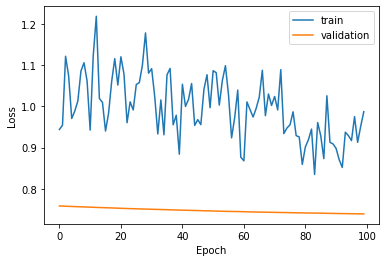

In [ ]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**Terlihat dari grafik di atas, perbandingan loss dari train model CNN dengan PCA dan validation loss model CNN dengan PCA. Dapat dilihat, loss train model yang dihasilkan naik turun seiring bertambahnya epoch, sedangkan validation loss yang dihasilkan hanya turun sedikit seiring bertambahnya epoch.**